# Gradient Boost

In [1]:
# Core
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve
)




In [7]:
def evaluar_umbral(y_true, y_proba, thr_list):
    from sklearn.metrics import confusion_matrix, classification_report
    for thr in thr_list:
        y_pred_thr = (y_proba >= thr).astype(int)
        print(f"\n===== UMBRAL {thr:.3f} =====")
        print("Matriz de confusión:\n", confusion_matrix(y_true, y_pred_thr))
        print(classification_report(y_true, y_pred_thr, digits=3))

In [2]:
# Carga de particiones ya preparadas
train_under = pd.read_csv("../data/bogie_train_under_1a5_windows.csv")
valid       = pd.read_csv("../data/bogie_valid_windows.csv")
test        = pd.read_csv("../data/bogie_test_windows.csv")


In [3]:
cols_to_exclude = [
    "timestamp",
    "train_id",
    "bogie_id",
    "target_fault",
    "alarm_level",
    "fault_type",
]

all_cols = train_under.columns.tolist()
feature_cols = [c for c in all_cols if c not in cols_to_exclude]

X_train = train_under[feature_cols].copy()
y_train = train_under["target_fault"].copy()

X_valid = valid[feature_cols].copy()
y_valid = valid["target_fault"].copy()


In [4]:
ratio = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    scale_pos_weight=ratio,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)



,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [5]:
y_valid_proba = xgb.predict_proba(X_valid)[:, 1]
y_valid_pred  = (y_valid_proba >= 0.5).astype(int)

cm = confusion_matrix(y_valid, y_valid_pred)
roc = roc_auc_score(y_valid, y_valid_proba)
pr_auc = average_precision_score(y_valid, y_valid_proba)

print("Matriz de confusión (valid):\n", cm)
print("\nROC-AUC (valid):", roc)
print("PR-AUC  (valid):", pr_auc)
print("\nInforme clasificación (valid):")
print(classification_report(y_valid, y_valid_pred, digits=3))



Matriz de confusión (valid):
 [[21170  7757]
 [  335   111]]

ROC-AUC (valid): 0.48664195831752755
PR-AUC  (valid): 0.014642426397068909

Informe clasificación (valid):
              precision    recall  f1-score   support

         0.0      0.984     0.732     0.840     28927
         1.0      0.014     0.249     0.027       446

    accuracy                          0.725     29373
   macro avg      0.499     0.490     0.433     29373
weighted avg      0.970     0.725     0.827     29373



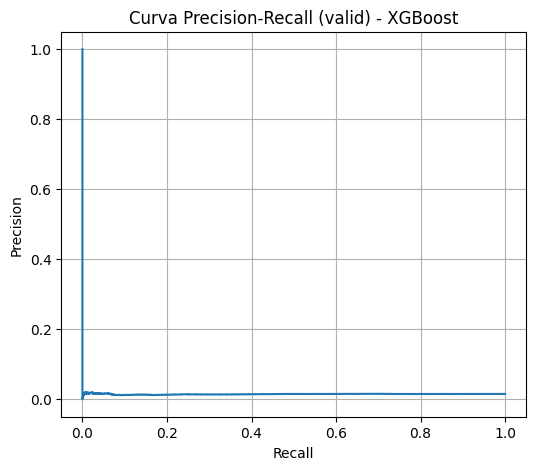

In [6]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_valid_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall (valid) - XGBoost")
plt.grid(True)
plt.show()

In [8]:
evaluar_umbral(y_valid, y_valid_proba, [0.5, 0.3, 0.2, 0.1])


===== UMBRAL 0.500 =====
Matriz de confusión:
 [[20734  8193]
 [  303   143]]
              precision    recall  f1-score   support

         0.0      0.986     0.717     0.830     28927
         1.0      0.017     0.321     0.033       446

    accuracy                          0.711     29373
   macro avg      0.501     0.519     0.431     29373
weighted avg      0.971     0.711     0.818     29373


===== UMBRAL 0.300 =====
Matriz de confusión:
 [[ 1483 27444]
 [   26   420]]
              precision    recall  f1-score   support

         0.0      0.983     0.051     0.097     28927
         1.0      0.015     0.942     0.030       446

    accuracy                          0.065     29373
   macro avg      0.499     0.496     0.064     29373
weighted avg      0.968     0.065     0.096     29373


===== UMBRAL 0.200 =====
Matriz de confusión:
 [[  172 28755]
 [    1   445]]
              precision    recall  f1-score   support

         0.0      0.994     0.006     0.012     28927


### Evaluación del modelo XGBoost

- Con el umbral estándar de 0,5, XGBoost identifica aproximadamente el 32 % de los fallos (recall de la clase 1 ≈ 0,32), pero a costa de 8.193 falsos positivos frente a solo 143 verdaderos positivos. La precisión de la clase 1 es muy baja (≈ 1,7 %), por lo que la gran mayoría de las alarmas generadas serían falsas.

- Al reducir el umbral (0,3; 0,2; 0,1) el modelo incrementa el recall hasta valores cercanos al 100 %, pero prácticamente todos los ejemplos son clasificados como fallo. Esto provoca que casi la totalidad de las alertas sean falsos positivos, lo que inutiliza el modelo para un entorno real de mantenimiento.

- Aunque XGBoost consigue un comportamiento algo mejor que otros modelos probados (detecta más fallos que Random Forest o Gradient Boosting), sigue sin ofrecer un equilibrio aceptable entre detección de fallos y número de falsas alarmas. La precisión extremadamente baja hace que el modelo no sea aplicable directamente a negocio sin mejoras adicionales en las variables o en el enfoque de modelado.
